In [1]:
import pandas as pd 
import numpy as np 

## Collecting the non-VSA peptides and the repeat motifs present in them 
## 7-mer repeats with conservative subs allowed at all positions 

df_hits = pd.read_csv('HITS_Round2_Pfonly_250kfil_techclean_3zscorefil_5patientsfil_withrepeatinfo_7mer_conservativesubs.csv',header=0,index_col=0)

print (df_hits.shape)

## Classifying peptides into repeats and non-repeats 

def repeat(row):
    
    freq = row.max_freq
    if freq >= 3:
        repeat = 'yes'
    else:
        repeat = 'no'
    return repeat

df_hits['repeat'] = df_hits.apply(repeat,axis=1)
 
df_hits_repeat = df_hits[df_hits['repeat']=='yes']
df_hits_norepeat = df_hits[df_hits['repeat']=='no']

print ('The number of peptides WITH repeats is ' + str(df_hits_repeat.shape[0]))
print ('The number of peptides WITHOUT repeats is ' + str(df_hits_norepeat.shape[0]))

## Take the peptides with repeats and collapse them based on repeat similarity so that repeat containing peptides are not redundantly counted 

import ast 
def collapse(df):
    motif_list = []
    for index, row in df.iterrows():
       
        motif = list(ast.literal_eval((row.sevenmer).split('-p1')[1]))
        motif = set([(row.sevenmer).split('-p1')[0]+x for x in motif]) ## retain the protein with the motifs so that motifs across proteins aree not collapsed 
        motif_list.append(motif)

### collect the indices of rows that represent redundant motifs once and remove rows that share at least one motif element with these indices
    ### Rationale is that if they share the samee element for top sevenmer, then their sevenmer freq will be same too 
    unique = set()
    common = set()
    i = 0
    for i in range(0,len(motif_list)):
        if i not in common:
            for j in range(0,len(motif_list)):
                if i != j:
                    match = motif_list[i].intersection(motif_list[j])
                    
                    if len(match)>0:
                        unique.add(i)
                        common.add(j)
                    else:
                        unique.add(i)  
                                   
    return list(unique)

df_hits_repeat_collpased = df_hits_repeat.iloc[:,np.r_[0:199,-3,-2,-1]]
df_hits_norepeat_collpased = df_hits_norepeat.iloc[:,np.r_[0:199,-3,-2,-1]]

collapsed_hit_count=[]
for i in range(0,199): ## collapsing peptide hits in each sample 
    if i%50 == 0:
        print (i)
    re_sample_df = df_hits_repeat_collpased.iloc[:,[i,-3]]
    re_sample_df.columns = ['sample','sevenmer']
    re_sample_df = re_sample_df[re_sample_df['sample']>0] ## only collect peptides which are hits in that sample 
 
    re_retained_rowindex = collapse(re_sample_df)
    ### remove IT orthologs of Antigen 332, gametocyte specific protein and FIKK 
    nhits = (re_sample_df.iloc[re_retained_rowindex].drop(re_sample_df.iloc[re_retained_rowindex].filter(regex='PFIT_1149200|PFIT_1037600|PFIT_0422900',axis=0).index,axis=0).shape[0])
    collapsed_hit_count.append(nhits)

collapsed_hit_count.append('NA') ## foor last column of max_sevenmer
collapsed_hit_count.append('NA') 
collapsed_hit_count.append('NA') 
df_hits_repeat_collpased.loc['repeat hits'] = collapsed_hit_count

### collapse the non-repeats as well so that overlapping peptides are counted once 

collapsed_hit_count=[]
for i in range(0,199): ## collapsing peptide hits in each sample 
    if i%50 == 0:
        print (i)
    re_sample_df = df_hits_norepeat_collpased.iloc[:,[i,-3]]
    re_sample_df.columns = ['sample','sevenmer']
    re_sample_df = re_sample_df[re_sample_df['sample']>0] ## only collect peptides which are hits in that sample 
 
    re_retained_rowindex = collapse(re_sample_df)
    ### remove IT orthologs of Antigen 332, gametocyte specific protein and FIKK 
    nhits = (re_sample_df.iloc[re_retained_rowindex].drop(re_sample_df.iloc[re_retained_rowindex].filter(regex='PFIT_1149200|PFIT_1037600|PFIT_0422900',axis=0).index,axis=0).shape[0])
    collapsed_hit_count.append(nhits)

collapsed_hit_count.append('NA') ## foor last column of max_sevenmer
collapsed_hit_count.append('NA') 
collapsed_hit_count.append('NA') 
df_hits_norepeat_collpased.loc['NO repeat hits'] = collapsed_hit_count



(5171, 291)
The number of peptides WITH repeats is 2372
The number of peptides WITHOUT repeats is 2799
0
50
100
150


/data/madhura/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


0
50
100
150


In [2]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import statistics

df_meta = pd.read_excel("Meta_data/200_samples_metadata_updated.xlsx",header=0,index_col = 'Barcode',engine='openpyxl') ##sample name is the index

# df_hits_nonrepeat = df_hits_norepeat.filter(regex='CK3|CT3',axis=1)
# df_hits_nonrepeat.loc['NO repeat hits'] = df_hits_nonrepeat.sum(axis=0)

# print ("The number of repeat peptides is ")
# print (df_hits_repeat_collpased.shape[1])
# print ("The number of NO repeat peptides is ")
# print (df_hits_nonrepeat.shape[1])

print ("The number of repeat peptides is ")
print (df_hits_repeat_collpased.shape[1])
print ("The number of NO repeat peptides is ")
print (df_hits_norepeat_collpased.shape[1])


## Breadth of NON-Repeeat peptides sharing motifs with other genes 

df_hits_nonrepeat_meta_combined = pd.merge(df_hits_norepeat_collpased.loc['NO repeat hits'], df_meta, left_index=True, right_index=True)
print (df_hits_nonrepeat_meta_combined.shape)

df_hits_repeat_meta_combined = pd.merge(df_hits_repeat_collpased.loc['repeat hits'], df_meta, left_index=True, right_index=True)
print (df_hits_repeat_meta_combined.shape)


from matplotlib import pyplot as plt 
import seaborn as sns
import scipy
sns.set(font_scale=1.2)
sns.set_style("whitegrid", {'axes.grid' : False})

def childadult(row):
    age = row.age

#     if (age >=7) & (age <= 11):
#         status = 'child_7_11'

#     elif (age >= 2) & (age < 4):
#         status = 'child_2_3'

#     elif (age >= 4) & (age < 7):
#         status = 'child_4_6'

    if (age >=2) & (age <= 11):
        status = 'child'
    else:
        status = 'adult'

    return status

def agecut(row):
    age = row.age

    if (age >= 2) & (age < 4):
        agecut = '2-3'

    elif (age >= 4) & (age < 7):
        agecut = '4-6'
    elif (age >= 7) & (age < 11):
        agecut = '7-11'
    else:
        agecut = '>18'
    return agecut

df_hits_nonrepeat_meta_combined['status'] = df_hits_nonrepeat_meta_combined.apply(childadult,axis=1)
df_hits_nonrepeat_meta_combined['agecut'] = df_hits_nonrepeat_meta_combined.apply(agecut,axis=1)


child_eir_geom3 = df_hits_nonrepeat_meta_combined[df_hits_nonrepeat_meta_combined['status'] == 'child'].eir_geom3
adult_eir_geom3 = df_hits_nonrepeat_meta_combined[df_hits_nonrepeat_meta_combined['status'] == 'adult'].eir_geom3

df_hits_repeat_meta_combined['status'] = df_hits_repeat_meta_combined.apply(childadult,axis=1)
df_hits_repeat_meta_combined['agecut'] = df_hits_repeat_meta_combined.apply(agecut,axis=1)


child_eir_geom3 = df_hits_repeat_meta_combined[df_hits_repeat_meta_combined['status'] == 'child'].eir_geom3
adult_eir_geom3 = df_hits_repeat_meta_combined[df_hits_repeat_meta_combined['status'] == 'adult'].eir_geom3


def eircut(row):
    eir = row.eir_geom3
    status = row.status

    if status == 'child':
        eir_50percent = child_eir_geom3.quantile(q=0.5)
        eir_75percent = child_eir_geom3.quantile(q=0.75)
        eir_25percent = child_eir_geom3.quantile(q=0.25)

    elif status == 'adult':
        eir_50percent = adult_eir_geom3.quantile(q=0.5)
        eir_75percent = adult_eir_geom3.quantile(q=0.75)
        eir_25percent = adult_eir_geom3.quantile(q=0.25)


    if eir <= eir_50percent:
        eir_cut = 'moderate'
    else:
        eir_cut = 'high'
    return eir_cut

df_hits_repeat_meta_combined['eircut'] = df_hits_repeat_meta_combined.apply(eircut,axis=1)
df_hits_nonrepeat_meta_combined['eircut'] = df_hits_nonrepeat_meta_combined.apply(eircut,axis=1)




The number of repeat peptides is 
202
The number of NO repeat peptides is 
202
(198, 20)
(198, 20)


# Figure 5 - supplement 4 

## Effect on time since infection on repeats 

In [5]:
kan_act = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']<=30)]
kan_act['infected'] = '0-30'
print (kan_act.shape)

kan_3060 = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']> 30)&(df_hits_repeat_meta_combined['tsi']< 60)]
kan_3060['infected'] = '30-60'
print (kan_3060.shape)

kan_mid = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>= 60)&(df_hits_repeat_meta_combined['tsi']< 120)]
kan_mid['infected'] = '60-120'
print (kan_mid.shape)

kan_late = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>= 120)&(df_hits_repeat_meta_combined['tsi']<= 240)]
kan_late['infected'] = '120-240'
print (kan_late.shape)

kan_solate = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>240)&(df_hits_repeat_meta_combined['tsi']<= 360)]
kan_solate['infected'] = '240-360'
print (kan_solate.shape)

kan_repeat = pd.concat([kan_act,kan_3060,kan_mid,kan_late,kan_solate])

(13, 24)
(7, 24)
(15, 24)
(15, 24)
(12, 24)


In [7]:
tor_act = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']<=30)]
tor_act['infected'] = '0-30'
print (tor_act.shape)

tor_3060 = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']> 30)&(df_hits_repeat_meta_combined['tsi']< 60)]
tor_3060['infected'] = '30-60'
print (tor_3060.shape)

tor_mid = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>= 60)&(df_hits_repeat_meta_combined['tsi']< 120)]
tor_mid['infected'] = '60-120'
print (tor_mid.shape)

tor_late = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>= 120)&(df_hits_repeat_meta_combined['tsi']<= 240)]
tor_late['infected'] = '120-240'
print (tor_late.shape)

tor_solate = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>240)&(df_hits_repeat_meta_combined['tsi']<= 360)]
tor_solate['infected'] = '240-360'
print (tor_solate.shape)

tor_repeat = pd.concat([tor_act,tor_3060,tor_mid,tor_late,tor_solate])

(46, 24)
(13, 24)
(10, 24)
(0, 24)
(0, 24)


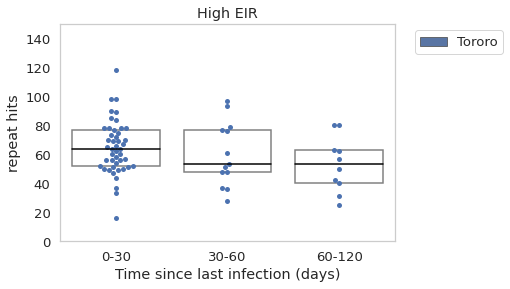

In [8]:
sns.swarmplot(x="infected", y="repeat hits", data=tor_repeat, dodge=True)
#sns.violinplot(x="infected", y="repeat hits", data=children_repeat,hue= 'siteid')

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="repeat hits", data=tor_repeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
plt.xlabel('Time since last infection (days)')
plt.ylim(0,150)
plt.title('High EIR')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.savefig('tsi_tororo.pdf',dpi=500)

In [13]:
import scipy 

x =tor_act['repeat hits'] 
x3060 = tor_3060['repeat hits'] 
y = tor_mid['repeat hits']

z=  tor_late['repeat hits'] 
a =  tor_solate['repeat hits'] 


print(scipy.stats.ks_2samp(x,y)) 




print (x.median())
print(x3060.median())
print(y.median())
print (z.median())
print(a.median())


KstestResult(statistic=0.3347826086956522, pvalue=0.25334125009106223)
64.0
53.0
53.5
nan
nan


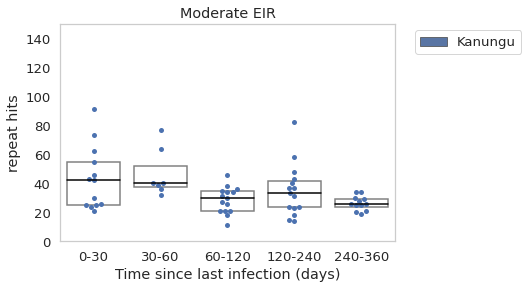

In [10]:
sns.swarmplot(x="infected", y="repeat hits", data=kan_repeat, dodge=True)
#sns.violinplot(x="infected", y="repeat hits", data=children_repeat,hue= 'siteid')

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="repeat hits", data=kan_repeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
plt.ylim(0,150)
plt.title('Moderate EIR')
plt.xlabel('Time since last infection (days)')
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.savefig('tsi_kanungu.pdf',dpi=500)

In [12]:
import scipy 

x =kan_act['repeat hits'] 
x3060 = kan_3060['repeat hits'] 
y = kan_mid['repeat hits']

z=  kan_late['repeat hits'] 
a =  kan_solate['repeat hits'] 


print(scipy.stats.ks_2samp(x,y)) 


print(scipy.stats.ks_2samp(x,z))


print(scipy.stats.ks_2samp(x,a))
print(scipy.stats.ks_2samp(y,a))
print(scipy.stats.ks_2samp(z,a))
print(scipy.stats.ks_2samp(y,z))



print (x.median())
print(x3060.median())
print(y.median())
print (z.median())
print(a.median())



KstestResult(statistic=0.4717948717948718, pvalue=0.05993372177246192)
KstestResult(statistic=0.2717948717948718, pvalue=0.5512036698737466)
KstestResult(statistic=0.5384615384615384, pvalue=0.024277830125185362)
KstestResult(statistic=0.3, pvalue=0.49578517084237916)
KstestResult(statistic=0.4666666666666667, pvalue=0.0783453157123909)
KstestResult(statistic=0.3333333333333333, pvalue=0.3855465198257425)
42.0
40.0
30.0
33.0
26.0


## Effect on time since infection on non-repeats 

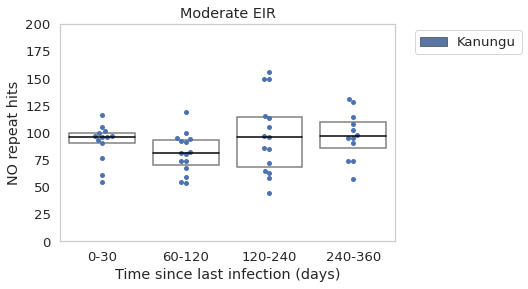

In [35]:
kan_act = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)  &(df_hits_nonrepeat_meta_combined['tsi']<=30)]
kan_act['infected'] = '0-30'


kan_mid = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>= 60)&(df_hits_nonrepeat_meta_combined['tsi']< 120)]
kan_mid['infected'] = '60-120'


kan_late = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>= 120)&(df_hits_nonrepeat_meta_combined['tsi']<= 240)]
kan_late['infected'] = '120-240'

kan_solate = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>240)&(df_hits_nonrepeat_meta_combined['tsi']<= 360)]
kan_solate['infected'] = '240-360'

kan_nonrepeat = pd.concat([kan_act,kan_mid,kan_late,kan_solate])

sns.swarmplot(x="infected", y="NO repeat hits", data=kan_nonrepeat, dodge=True)
#sns.violinplot(x="infected", y="repeat hits", data=children_repeat,hue= 'siteid')

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="NO repeat hits", data=kan_nonrepeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
plt.ylim(0,200)
plt.title('Moderate EIR')
plt.xlabel('Time since last infection (days)')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('tsi_kanungu_nonrepeats.pdf')

In [36]:
import scipy 

x =kan_act['NO repeat hits'] 
y = kan_mid['NO repeat hits']

z=  kan_late['NO repeat hits'] 
a =  kan_solate['NO repeat hits'] 


print(scipy.stats.ks_2samp(x,y)) 


print(scipy.stats.ks_2samp(x,z))


print(scipy.stats.ks_2samp(x,a))
print(scipy.stats.ks_2samp(y,z))
print(scipy.stats.ks_2samp(y,a))



print (x.median())
print(y.median())
print (z.median())
print(a.median())


KstestResult(statistic=0.48205128205128206, pvalue=0.054136620323186446)
KstestResult(statistic=0.2564102564102564, pvalue=0.6388289564490938)
KstestResult(statistic=0.26282051282051283, pvalue=0.6906278483933619)
KstestResult(statistic=0.4, pvalue=0.18441617684449832)
KstestResult(statistic=0.4666666666666667, pvalue=0.0783453157123909)
96.0
81.0
96.0
96.5


KstestResult(statistic=0.27391304347826084, pvalue=0.4790529072473483)
98.5
88.5
nan
nan


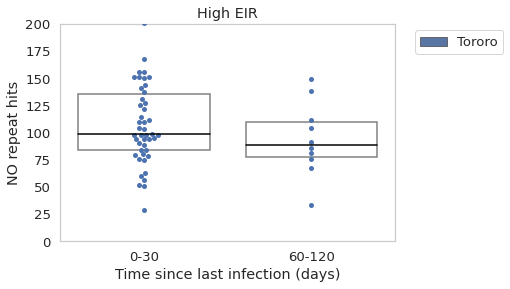

In [37]:
tor_act = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)  &(df_hits_nonrepeat_meta_combined['tsi']<=30)]
tor_act['infected'] = '0-30'


tor_mid = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>= 60)&(df_hits_nonrepeat_meta_combined['tsi']< 120)]
tor_mid['infected'] = '60-120'


tor_late = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>= 120)&(df_hits_nonrepeat_meta_combined['tsi']<= 240)]
tor_late['infected'] = '120-240'

tor_solate = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>240)&(df_hits_nonrepeat_meta_combined['tsi']<= 360)]
tor_solate['infected'] = '240-360'

tor_nonrepeat = pd.concat([tor_act,tor_mid,tor_late,tor_solate])

sns.swarmplot(x="infected", y="NO repeat hits", data=tor_nonrepeat, dodge=True)
#sns.violinplot(x="infected", y="repeat hits", data=children_repeat,hue= 'siteid')

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="NO repeat hits", data=tor_nonrepeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
plt.ylim(0,200)
plt.title('High EIR')
plt.xlabel('Time since last infection (days)')

plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.savefig('tsi_tororo_nonrepeats.pdf')

import scipy 

x =tor_act['NO repeat hits'] 
y = tor_mid['NO repeat hits']

z=  tor_late['NO repeat hits'] 
a =  tor_solate['NO repeat hits'] 


print(scipy.stats.ks_2samp(x,y)) 




print (x.median())
print(y.median())
print (z.median())
print(a.median())


# Figure 5 - supplement 3

## Effect on exposure on repeats 

In [56]:

kan_children_active = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']==0)]
kan_children_active['infected'] = '0'
print (kan_children_active.shape)

kan_children_early = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']>= 1)&(df_hits_repeat_meta_combined['tsi']< 60)]
kan_children_early['infected'] = '1-59'
print (kan_children_early.shape)

kan_children_late = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Kanungu') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']>= 60)&(df_hits_repeat_meta_combined['tsi']<= 120)]
kan_children_late['infected'] = '60-120'
print (kan_children_late.shape)

tor_children_active = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)&(df_hits_repeat_meta_combined['tsi']==0)]
tor_children_active['infected'] = '0'
print (tor_children_active.shape)

tor_children_early = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']>= 1)&(df_hits_repeat_meta_combined['tsi']< 60)]
tor_children_early['infected'] = '1-59'
print (tor_children_early.shape)


tor_children_late = df_hits_repeat_meta_combined[(df_hits_repeat_meta_combined['siteid']=='Tororo') &(df_hits_repeat_meta_combined['age']<18)  &(df_hits_repeat_meta_combined['tsi']>= 60)&(df_hits_repeat_meta_combined['tsi']<= 120)]
tor_children_late['infected'] = '60-120'
print (tor_children_late.shape)

#children_repeat = pd.concat([kan_children_active.sample(n=10),kan_children_late.sample(n=10),tor_children_active.sample(n=10),tor_children_late.sample(n=10)])

children_repeat = pd.concat([kan_children_active,kan_children_early, kan_children_late,tor_children_active,tor_children_early,tor_children_late])


(11, 24)
(9, 24)
(15, 24)
(44, 24)
(15, 24)
(10, 24)


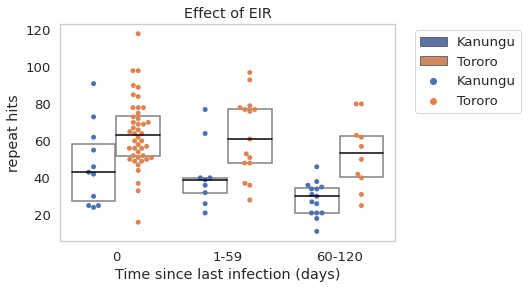

In [57]:
palette = {'moderate':'blue','high':'darkorange'}

children_repeat['repeat hits'] = children_repeat['repeat hits'].astype('float64')
sns.swarmplot(x="infected", y="repeat hits", data=children_repeat, dodge=True,hue= 'siteid')
#sns.violinplot(x="infected", y="repeat hits", data=children_repeat,hue= 'siteid')

sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="repeat hits", data=children_repeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
plt.title('Effect of EIR')
plt.xlabel('Time since last infection (days)')

#plt.ylim(0,150)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
#plt.savefig('eir_repeats.pdf')


In [41]:
import scipy 

x = children_repeat[(children_repeat['infected']=='0')& (children_repeat['siteid']=='Kanungu')]['repeat hits'] 
y = children_repeat[(children_repeat['infected']=='60-120')& (children_repeat['siteid']=='Kanungu')]['repeat hits']

z=  children_repeat[(children_repeat['infected']=='0')& (children_repeat['siteid']=='Tororo')]['repeat hits'] 
a =  children_repeat[(children_repeat['infected']=='60-120')& (children_repeat['siteid']=='Tororo')]['repeat hits'] 

print ('Kanungu yes and no')
print(scipy.stats.ks_2samp(x,y)) 

print ('Tororo yes and no')
print(scipy.stats.ks_2samp(z,a))

print ('Places yes')
print(scipy.stats.ks_2samp(z,x))

print ('Places no')
print(scipy.stats.ks_2samp(a,y)) 
 


print (x.median())
print(y.median())
print (z.median())
print(a.median())


Kanungu yes and no
KstestResult(statistic=0.5696969696969697, pvalue=0.02048262008552748)
Tororo yes and no
KstestResult(statistic=0.33181818181818185, pvalue=0.2679160461476544)
Places yes
KstestResult(statistic=0.5454545454545454, pvalue=0.007125575840078446)
Places no
KstestResult(statistic=0.7333333333333333, pvalue=0.001467223044824384)
43.0
30.0
63.0
53.5


## Effect on exposure on non-repeats 

In [45]:


kan_children_active = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)  &(df_hits_nonrepeat_meta_combined['tsi']==0)]
kan_children_active['infected'] = '0'
print (kan_children_active.shape)

kan_children_late = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Kanungu') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']>= 60)&(df_hits_nonrepeat_meta_combined['tsi']<= 120)]
kan_children_late['infected'] = '60-120'
print (kan_children_late.shape)

tor_children_active = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)&(df_hits_nonrepeat_meta_combined['tsi']==0)]
tor_children_active['infected'] = '0'
print (tor_children_active.shape)

tor_children_late = df_hits_nonrepeat_meta_combined[(df_hits_nonrepeat_meta_combined['siteid']=='Tororo') &(df_hits_nonrepeat_meta_combined['age']<18)  &(df_hits_nonrepeat_meta_combined['tsi']>= 60)&(df_hits_nonrepeat_meta_combined['tsi']<= 120)]
tor_children_late['infected'] = '60-120'
print (tor_children_late.shape)

children_nonrepeat = pd.concat([kan_children_active,kan_children_late,tor_children_active,tor_children_late])


(11, 24)
(15, 24)
(44, 24)
(10, 24)


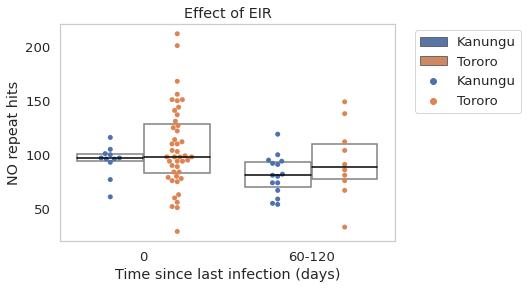

In [46]:
palette = {'moderate':'blue','high':'darkorange'}

sns.swarmplot(x="infected", y="NO repeat hits", data=children_nonrepeat, dodge=True,hue= 'siteid')
sns.boxplot(medianprops={'visible': True,'color':'black'},
            whiskerprops={'visible': False},
            zorder=10,
            x="infected", y="NO repeat hits", data=children_nonrepeat,hue= 'siteid', dodge= True,
            showfliers=False,
            showbox=True,
            showcaps=False,
            boxprops={'facecolor':'none', 'edgecolor':'grey'})
#plt.ylim(0,200)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
plt.title('Effect of EIR')
plt.xlabel('Time since last infection (days)')

plt.savefig('eir_nonrepeats.pdf',dpi=500)

In [48]:
import scipy 

x = children_nonrepeat[(children_nonrepeat['infected']=='0')& (children_nonrepeat['siteid']=='Kanungu')]['NO repeat hits'] 
y = children_nonrepeat[(children_nonrepeat['infected']=='60-120')& (children_nonrepeat['siteid']=='Kanungu')]['NO repeat hits']

z=  children_nonrepeat[(children_nonrepeat['infected']=='0')& (children_nonrepeat['siteid']=='Tororo')]['NO repeat hits'] 
a =  children_nonrepeat[(children_nonrepeat['infected']=='60-120')& (children_nonrepeat['siteid']=='Tororo')]['NO repeat hits'] 

print ('Kanungu yes and no')
print(scipy.stats.ks_2samp(x,y)) 

print ('Tororo yes and no')
print(scipy.stats.ks_2samp(z,a))

print ('Places yes')
print(scipy.stats.ks_2samp(z,x))

print ('Places no')
print(scipy.stats.ks_2samp(a,y)) 
 

print (x.median())
print(y.median())
print (z.median())
print(a.median())


Kanungu yes and no
KstestResult(statistic=0.593939393939394, pvalue=0.013578802406370105)
Tororo yes and no
KstestResult(statistic=0.2590909090909091, pvalue=0.5527141187159196)
Places yes
KstestResult(statistic=0.3181818181818182, pvalue=0.300259004541819)
Places no
KstestResult(statistic=0.3333333333333333, pvalue=0.46227315556969617)
97.0
81.0
98.0
88.5
